<a href="https://colab.research.google.com/github/yifengd/adversarial-nlp/blob/main/defenses/captum/catum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Based on: Explain Attacking BERT models using CAptum

Captum is a PyTorch library to explain neural networks
Here we show a minimal example using Captum to explain BERT models from TextAttack

[![Open Notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yifengd/adversarial-nlp/blob/main/defenses/captum/catum.ipynb)

[![Original Code on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/QData/TextAttack/blob/master/docs/2notebook/Example_5_Explain_BERT.ipynb)

In [1]:
!pip install textattack[tensorflow] tensorflow_text==2.10.0b2 captum nltk -q 

     |████████████████████████████████| 415 kB 4.3 MB/s 
     |████████████████████████████████| 5.7 MB 62.8 MB/s 
     |████████████████████████████████| 1.4 MB 77.4 MB/s 
     |████████████████████████████████| 60 kB 8.2 MB/s 
     |████████████████████████████████| 3.6 MB 74.6 MB/s 
     |████████████████████████████████| 769 kB 80.3 MB/s 
     |████████████████████████████████| 4.4 MB 45.6 MB/s 
     |████████████████████████████████| 41.4 MB 236 kB/s 
     |████████████████████████████████| 401 kB 69.0 MB/s 
     |████████████████████████████████| 290 kB 61.8 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 373 kB 70.0 MB/s 
     |████████████████████████████████| 69 kB 6.8 MB/s 
     |████████████████████████████████| 365 kB 81.0 MB/s 
     |████████████████████████████████| 361 kB 91.7 MB/s 
     |████████████████████████████████| 125 kB 80.1 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |█████████████

In [2]:
import torch
from copy import deepcopy
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.models.wrappers import ModelWrapper
from transformers import AutoModelForSequenceClassification, AutoTokenizer

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:34<00:00, 14.2MB/s]
textattack: Unzipping file /root/.cache/textattack/tmp6tfd0zub.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Su

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")
    
print(f"Using accelerator {device}")

Using accelerator cuda:0


## Configure Model and Dataset

In [4]:
dataset = HuggingFaceDataset("ag_news", None, "train")
original_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-ag-news")
original_tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news")
model = HuggingFaceModelWrapper(original_model,original_tokenizer)

Using custom data configuration default


textattack: Loading datasets dataset ag_news, split train.


Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a. Subsequent calls will reuse this data.


In [ ]:
print(model.model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Perform TextAttack

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from textattack.attack_recipes import PWWSRen2019
attack = PWWSRen2019.build(model)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
from textattack import Attacker
from textattack import AttackArgs

# attacker = Attacker(attack, dataset, attack_args=AttackArgs(num_successful_examples=100, parallel=True))
# results = attacker.attack_dataset()

## Construct Dataframe of Original and Perturbed Samples

In [ ]:
# adversarial_df = pd.DataFrame([{
#     "original_text": result.original_result.attacked_text.text,
#     "perturbed_text": result.perturbed_result.attacked_text.text,
#     "original_output": result.perturbed_result.ground_truth_output,
#     "perturbed_output": result.perturbed_result.output
#   }
#  for result in results])
# adversarial_df["result_type"] = np.where(adversarial_df["original_output"] == adversarial_df["perturbed_output"], "Failed", "Successful")
# adversarial_df = adversarial_df[adversarial_df["result_type"] == "Successful"]
# adversarial_df.to_csv("/content/pwws_attack.csv", index=False)

NameError: ignored

In [21]:
adversarial_df = pd.read_csv("/content/pwws_attack.csv")
adversarial_df = adversarial_df.head(-1)

## Calculate Attributions in Original and Perturbed Samples

In [22]:
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerDeepLiftShap, InternalInfluence, LayerGradientXActivation, LayerActivation
from captum.attr import visualization as viz

def calculate(input_ids,token_type_ids,attention_mask):
    #convert back to list of text
    return clone.model(input_ids,token_type_ids,attention_mask)[0]

clone = deepcopy(model)
clone.model.to(device)

for text_type in ["original", "perturbed"]:
  # lig = LayerIntegratedGradients(calculate, clone.model.bert.embeddings)
  lig = LayerActivation(calculate, clone.model.bert.embeddings)
  # lig = InternalInfluence(calculate, clone.model.bert.embeddings)
  # lig = LayerGradientXActivation(calculate, clone.model.bert.embeddings)
  # lig = LayerDeepLiftShap(calculate, clone.model.bert.embeddings)
  # lig = IntegratedGradients(calculate, clone.model.bert.embeddings)
  # lig = LayerConductance(calculate, clone.model.bert.embeddings)

  tokens = model.tokenizer([sentence for sentence in adversarial_df[f"{text_type}_text"]], padding=True, return_tensors="pt").to(device)
  adversarial_df[f"{text_type}_tokens"] = [tokens[x].tokens for x in range(tokens.input_ids.shape[0])]

  bsl = torch.zeros(tokens['input_ids'].size()).type(torch.LongTensor).to(device)
  labels = [i for i in adversarial_df[f"{text_type}_output"]]
  labels = torch.tensor(labels).to(device)

  attributions = lig.attribute(inputs=tokens['input_ids'],
                                #baselines=bsl,
                                additional_forward_args=(tokens['token_type_ids'], tokens['attention_mask']),
                                #n_steps = 10,
                                # target = labels,
                                # internal_batch_size=1
                                )
  atts = attributions.sum(dim=-1).squeeze(0)
  atts = atts / torch.norm(atts)
  adversarial_df[f"{text_type}_attribution"] = (atts * tokens.attention_mask).cpu().detach().numpy().tolist()

In [23]:
del lig

# prints currently alive Tensors and Variables
import torch
import gc
gc.collect()

torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  550940 KB |    6389 MB |   67216 MB |   66678 MB |
|       from large pool |  549888 KB |    6386 MB |   67200 MB |   66663 MB |
|       from small pool |    1052 KB |       3 MB |      16 MB |      15 MB |
|---------------------------------------------------------------------------|
| Active memory         |  550940 KB |    6389 MB |   67216 MB |   66678 MB |
|       from large pool |  549888 KB |    6386 MB |   67200 MB |

## Inspect Attributions

In [24]:
adversarial_df

,Unnamed: 0,original_text,perturbed_text,original_output,perturbed_output,result_type,original_tokens,original_attribution,perturbed_tokens,perturbed_attribution
0,0,Wall St. Bears Claw Back Into the Black (Reute...,Wall St. suffer Claw Back Into the lightlessne...,2,3,Successful,"[[CLS], wall, st, ., bears, claw, back, into, ...","[-0.006909027695655823, 0.0012986246729269624,...","[[CLS], wall, st, ., suffer, claw, back, into,...","[-0.00685918889939785, 0.0012892568483948708, ..."
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...,Carlyle Looks Toward Commercial Aerospace (Reu...,2,3,Successful,"[[CLS], carly, ##le, looks, toward, commercial...","[-0.006909027695655823, -0.00847606360912323, ...","[[CLS], carly, ##le, looks, toward, commercial...","[-0.00685918889939785, -0.00841492135077715, 0..."
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Oil and Economy swarm Stocks' Outlook (Reuters...,2,3,Successful,"[[CLS], oil, and, economy, cloud, stocks, ', o...","[-0.006909027695655823, -0.0011789610143750906...","[[CLS], oil, and, economy, swarm, stocks, ', o...","[-0.00685918889939785, -0.0011704564094543457,..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Iraq kibosh Oil Exports from Main Southern Pip...,2,0,Successful,"[[CLS], iraq, halt, ##s, oil, exports, from, m...","[-0.006909027695655823, -0.0067503987811505795...","[[CLS], iraq, ki, ##bos, ##h, oil, exports, fr...","[-0.00685918889939785, -0.006701704114675522, ..."
4,4,"Oil prices soar to all-time record, posing new...","Oil prices soar to all-time record, posing new...",2,0,Successful,"[[CLS], oil, prices, so, ##ar, to, all, -, tim...","[-0.006909027695655823, -0.0011789610143750906...","[[CLS], oil, prices, so, ##ar, to, all, -, tim...","[-0.00685918889939785, -0.0011704564094543457,..."
...,...,...,...,...,...,...,...,...,...,...
79,89,Charley's Force Took Experts by Surprise (AP) ...,Charley's violence accept Experts by Surprise ...,3,0,Successful,"[[CLS], charley, ', s, force, took, experts, b...","[-0.006909027695655823, -0.00724891759455204, ...","[[CLS], charley, ', s, violence, accept, exper...","[-0.00685918889939785, -0.007196627091616392, ..."
80,90,"Science, Politics Collide in Election Year (AP...","Science, Politics clash in Election class (AP)...",3,0,Successful,"[[CLS], science, ,, politics, col, ##lide, in,...","[-0.006909027695655823, -0.0012998387683182955...","[[CLS], science, ,, politics, clash, in, elect...","[-0.00685918889939785, -0.0012904623290523887,..."
81,92,Russian Cargo Craft Docks at Space Station (AP...,Russian Cargo trade Docks at place Station (AP...,3,0,Successful,"[[CLS], russian, cargo, craft, docks, at, spac...","[-0.006909027695655823, -0.0015467304037883878...","[[CLS], russian, cargo, trade, docks, at, plac...","[-0.00685918889939785, -0.0015355729265138507,..."
82,93,Bangkok's Canals Losing to Urban Sprawl (AP) A...,Bangkok's Canals Losing to Urban sprawling (AP...,3,0,Successful,"[[CLS], bangkok, ', s, canals, losing, to, urb...","[-0.006909027695655823, -0.00776950316503644, ...","[[CLS], bangkok, ', s, canals, losing, to, urb...","[-0.00685918889939785, -0.007713457103818655, ..."


## Plot Attributions of Original and Perturbed Samples

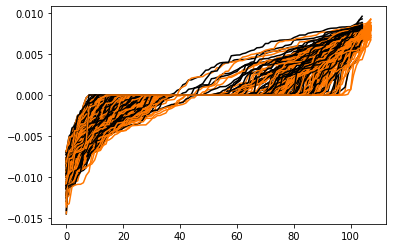

In [25]:
num_rows, _ = adversarial_df.shape
fig, ax = plt.subplots()
for i in range(num_rows):
  ax.plot(np.sort(adversarial_df.iloc[i].original_attribution), color="black")
  ax.plot(np.sort(adversarial_df.iloc[i].perturbed_attribution), color="#FF7700")

# num_rows, _ = adversarial_df.shape
# fig, axs = plt.subplots(num_rows, 1, figsize=(10, num_rows*5))

# for i in range(num_rows):
#   axs[i].plot(np.sort(adversarial_df.iloc[i].original_attribution), color="black")
#   axs[i].plot(np.sort(adversarial_df.iloc[i].perturbed_attribution), color="#FF7700")
#   axs[i].set_title(f"{adversarial_df.iloc[i].original_text}\n{adversarial_df.iloc[i].perturbed_text}")

## Preprocess the Dataframe

In [26]:
max_tokens_original = adversarial_df["original_attribution"].apply(lambda x: len(x)).max()
max_tokens_perturbed = adversarial_df["perturbed_attribution"].apply(lambda x: len(x)).max()

In [27]:
# X_original = adversarial_df["original_attribution"].apply(lambda x: np.array(x)).to_numpy()
# X_perturbed = adversarial_df["perturbed_attribution"].apply(lambda x: np.array(x)).to_numpy()

# Y_original = np.zeros(X_original.shape[0])
# Y_perturbed = np.ones(X_perturbed.shape[0])

# X = np.concatenate((X_original, X_perturbed))
# Y = np.concatenate((Y_original, Y_perturbed))

# # Fix the padding to alywas match n
# max_tokens = max(max_tokens_original, max_tokens_perturbed)
# X = [np.pad(x, (0, max_tokens-x.shape[0])) for x in X]

# # Convert array of arrays to 2D-array
# X = np.stack(X)

# X, Y = sklearn.utils.shuffle(X, Y, random_state=42)

In [28]:
def make_samples(df):
  X_original = df["original_attribution"].apply(lambda x: np.array(x)).to_numpy()
  X_perturbed = df["perturbed_attribution"].apply(lambda x: np.array(x)).to_numpy()

  Y_original = np.zeros(X_original.shape[0])
  Y_perturbed = np.ones(X_perturbed.shape[0])

  X = np.concatenate((X_original, X_perturbed))
  Y = np.concatenate((Y_original, Y_perturbed))

  # Fix the padding to alywas match n
  max_tokens = max(max_tokens_original, max_tokens_perturbed)
  X = [np.pad(x, (0, max_tokens-x.shape[0])) for x in X]

  # Convert array of arrays to 2D-array
  X = np.stack(X)

  X, Y = sklearn.utils.shuffle(X, Y, random_state=42)
  return X, Y

In [29]:
shuffled_df = adversarial_df.sample(frac=1)
train_df = shuffled_df.iloc[:int(len(shuffled_df) * 0.7)]
test_df = shuffled_df.iloc[int(len(shuffled_df) * 0.7):]

## Train an Adversarial Detector

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

x_train, y_train = make_samples(train_df)
x_test, y_test = make_samples(test_df)

# cls = sklearn.naive_bayes.GaussianNB()
cls = RandomForestClassifier()
cls.fit(x_train, y_train)
preds = cls.predict(x_test)
# draw_confusion_matrix(y_test, preds, "Gaussian Naive Bayes")

print(sklearn.metrics.classification_report(y_train, cls.predict(x_train)))
print(sklearn.metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        58
         1.0       1.00      1.00      1.00        58

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        26
         1.0       1.00      1.00      1.00        26

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



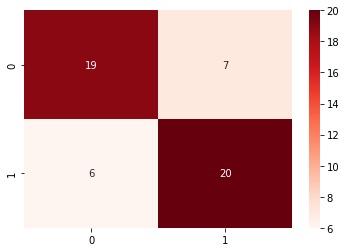

In [19]:
import seaborn as sns

sns.heatmap(sklearn.metrics.confusion_matrix(y_test, preds), annot=True, cmap="Reds")